In [18]:
import numpy as np
from scipy.optimize import minimize

In [19]:
import pickle
import os
# take in all the data from the files that don't start with 'np' and dont have 'double' in the file name
def get_data():
    data = []
    # see list of files from data directory
    files = os.listdir('data')
    for file in files:
        if file[0:2] != 'np' and 'double' not in file:
            print(f"found file: {file}")
            with open('data/' + file, 'rb') as f:
                data.append(pickle.load(f))
    return data
result_data = get_data()

found file: plus_i_state_tomography_single.pickle
found file: zero_state_tomography_single.pickle
found file: minus_i_state_tomography_single.pickle
found file: minus_state_tomography_single.pickle
found file: one_state_tomography_single.pickle
found file: plus_state_tomography_single.pickle


In [29]:
result_state_labels = ['+i','0','-i','-','1','+']

In [20]:
np.array(result_data).shape

(6, 127, 2, 2)

In [25]:
# initial states are |0>, |1>, |+>, |->, |+i>, |-i>
state_labels = ['0','1','+','-']
from qiskit.quantum_info import Statevector, DensityMatrix
for label in state_labels:
    state = Statevector.from_label(label)
    rho = DensityMatrix(state).data
    print(f"|{label}> = {rho}")

# now I have to do the states for the +i and -i states
# |+i> = 1/sqrt(2) * (|0> + i|1>)
# |-i> = 1/sqrt(2) * (|0> - i|1>)
print('----------------')
plusI = 1/np.sqrt(2) * (np.array([1,0]) + 1j*np.array([0,1]))
print(plusI)
state = Statevector(plusI)
rho = DensityMatrix(state).data
print(f"|+i> = {rho}")
print('----------------')
minusI = 1/np.sqrt(2) * (np.array([1,0]) - 1j*np.array([0,1]))
print(minusI)
state = Statevector(minusI)
rho = DensityMatrix(state).data
print(f"|-i> = {rho}")

|0> = [[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
|1> = [[0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j]]
|+> = [[0.5+0.j 0.5+0.j]
 [0.5+0.j 0.5+0.j]]
|-> = [[ 0.5+0.j -0.5-0.j]
 [-0.5+0.j  0.5+0.j]]
----------------
[0.70710678+0.j         0.        +0.70710678j]
|+i> = [[0.5+0.j  0. -0.5j]
 [0. +0.5j 0.5+0.j ]]
----------------
[0.70710678+0.j         0.        -0.70710678j]
|-i> = [[0.5+0.j  0. +0.5j]
 [0. -0.5j 0.5+0.j ]]


In [12]:
result_data = np.array(result_data)

In [26]:
pauliZ = np.array([[1, 0], [0, -1]])
plusOp = np.array([[0,0],[1,0]])
lowerOp = np.array([[0,1],[0,0]])
def apply_libladian(rho, *args):
    """
    Applies the Lindbladian to the density matrix rho
    Args:
        rho: the density matrix
        args: the parameters for the Lindbladian - [f, omega_Z, gamma_Z, gamma_AD]
    """
    f, omega_Z, gamma_Z, gamma_AD = args[0]
    H = lambda omega: -0.5*omega*pauliZ
    return -1j*(H(omega_Z) @ rho - rho @ H(omega_Z)) - gamma_Z*(pauliZ @ rho @ pauliZ - rho) - gamma_AD*(1-f)*(lowerOp @ rho @ plusOp - 0.5*(plusOp @ lowerOp @ rho + rho @ plusOp @ lowerOp)) + gamma_AD*f*(plusOp @ rho @ lowerOp - 0.5*(lowerOp @ plusOp @ rho + rho @ lowerOp @ plusOp))

In [51]:
from qiskit.quantum_info import random_density_matrix
import numpy as np

rand = random_density_matrix(2).data

# Define Pauli matrices
sigma_x = np.array([[0, 1], [1, 0]], dtype=complex)
sigma_y = np.array([[0, -1j], [1j, 0]], dtype=complex)
sigma_z = np.array([[1, 0], [0, -1]], dtype=complex)

# Function to convert density matrix to Bloch vector
def density_matrix_to_bloch_vector(rho):
    bloch_vector = np.zeros(3)
    pauli_matrices = [sigma_x, sigma_y, sigma_z]
    
    for i in range(3):
        bloch_vector[i] = np.trace(np.dot(rho, pauli_matrices[i]))
    
    return np.real(bloch_vector)

bloch_vector = density_matrix_to_bloch_vector(rand)
print(bloch_vector)

# Fucntion to convert from Bloch vector to density matrix
def bloch_vector_to_density_matrix(bloch_vector):
    bloch_vector = np.array(bloch_vector)
    return 0.5*(np.identity(2) + bloch_vector[0]*sigma_x + bloch_vector[1]*sigma_y + bloch_vector[2]*sigma_z)

def norm_of_bloch_vector(bloch_vector):
    return np.linalg.norm(bloch_vector)

print(norm_of_bloch_vector(bloch_vector))

[-0.59141519  0.40538752 -0.13440305]
0.7295033591241221


/var/folders/8r/fcck2fx56mz4lc18dwtykgtw0000gn/T/ipykernel_1246/547080289.py:17: ComplexWarning: Casting complex values to real discards the imaginary part
  bloch_vector[i] = np.trace(np.dot(rho, pauli_matrices[i]))


In [34]:
# turn all the result data into bloch vectors
bloch_result_data = []
for basis in range(len(result_data)):
    bloch_result_data.append([])
    for i in range(len(result_data[basis])):
        bloch_result_data[basis].append(density_matrix_to_bloch_vector(result_data[basis][i]))
bloch_result_data = np.array(bloch_result_data)
bloch_result_dict = {}
for i in range(len(result_data)):
    bloch_result_dict[result_state_labels[i]] = bloch_result_data[i]

/var/folders/8r/fcck2fx56mz4lc18dwtykgtw0000gn/T/ipykernel_1246/3838099315.py:17: ComplexWarning: Casting complex values to real discards the imaginary part
  bloch_vector[i] = np.trace(np.dot(rho, pauli_matrices[i]))


In [35]:
bloch_result_data.shape

(6, 127, 3)

In [48]:
# finding target gradients of the bloch vectors
target_grads_dict = {}
for key, val in bloch_result_dict.items():
    target_grads_dict[key] = np.gradient(val, axis=0) # this is an approximation of the gradient

In [58]:
len(target_grads_dict['+i'])

127

In [119]:
from scipy.optimize import minimize
import numpy as np

def get_initial_guess():
    # Setting the size for 127 time steps, 4 parameters each
    f = np.random.uniform(0, 0.5, 127)  # Uniform distribution between 0 and 0.5 for 'f'
    omega_Z = np.random.uniform(0, 1, 127)    # Uniform distribution between 0 and 1 for 'b', you can adjust the upper bound as needed
    gamma_Z = np.random.uniform(0, 1, 127)    # Uniform distribution between 0 and 1 for 'c', you can adjust the upper bound as needed
    gamma_AD = np.random.uniform(0, 1, 127) 

    # Stack these arrays to form an initial_guess matrix of shape (127, 4)
    initial_guess = np.vstack((f, omega_Z, gamma_Z, gamma_AD)).T.flatten()  # Transpose and flatten to match the expected shape

    return initial_guess

In [122]:
def get_optimal_linbladian_time_dependent_parameters_of_specific_initial_state(optimization_type='L-BFGS-B', initial_states=['+']):
    def mod_loss_of_bloch_vectors(parameters, target_grads_dict, bloch_result_dict, initial_states):
        """
        Function that calculates the loss of the bloch vectors
        Args:
            parameters: the parameters of the lindbladian
            target_grads_dict: the target gradients of the bloch vectors
            bloch_result_dict: the bloch vectors of the result data
        """
        parameters = parameters.reshape((127, 4))
        loss = 0
        for key in initial_states:
            target_grads = target_grads_dict[key]
            
            bloch_result = bloch_result_dict[key]
            rho_result = [bloch_vector_to_density_matrix(bloch) for bloch in bloch_result]
            for i, rho in enumerate(rho_result):
                temp_grad_rho = apply_libladian(rho, parameters[i])
                linblad_bloch_result = density_matrix_to_bloch_vector(temp_grad_rho)
                loss += np.sum((linblad_bloch_result - target_grads[i])**2)
        return loss

    # Define bounds for each parameter at each time step
    bounds = []
    for _ in range(127):
        # bounds for: f, omega_Z, gamma_Z, gamma_AD
        bounds.extend([(0, 0.5), (0, 1), (0, 1), (0, 1)])  # Using a very small value close to zero for d > 0

    bounds = np.array(bounds)
    # Initial guess of the parameters
    initial_guess = get_initial_guess()

    # Minimize the loss function
    result = minimize(
        mod_loss_of_bloch_vectors,
        initial_guess,
        args=(target_grads_dict, bloch_result_dict, initial_states),
        method=optimization_type,
        bounds=bounds
    )
    total_loss = result.fun
    parameters = result.x.reshape((127, 4))
    return total_loss, parameters

In [123]:
loss_plus, params_plus = get_optimal_linbladian_time_dependent_parameters_of_specific_initial_state(initial_states=['+'])
print("Plus state optimization")
print(f"loss = {loss_plus}")
print(params_plus[0])

/var/folders/8r/fcck2fx56mz4lc18dwtykgtw0000gn/T/ipykernel_1246/547080289.py:17: ComplexWarning: Casting complex values to real discards the imaginary part
  bloch_vector[i] = np.trace(np.dot(rho, pauli_matrices[i]))


Plus state optimization
loss = 2.451757051838249
[0.49412935 0.08883899 0.0912245  0.07810604]


In [108]:
loss_plus, params_plus = get_optimal_linbladian_time_dependent_parameters_of_specific_initial_state(initial_states=['+'])
print("Plus state optimization")
print(f"loss = {loss_plus}")
print(params_plus[0])
loss_minus, params_minus = get_optimal_linbladian_time_dependent_parameters_of_specific_initial_state(initial_states=['-'])
print("Minus state optimization")
print(f"loss = {loss_minus}")
print(params_minus[0])
loss_plus_minus, params_plus_minus = get_optimal_linbladian_time_dependent_parameters_of_specific_initial_state(initial_states=['+','-'])
print("Plus and Minus state optimization")
print(f"loss = {loss_plus_minus}")
print(params_plus_minus[0])

/var/folders/8r/fcck2fx56mz4lc18dwtykgtw0000gn/T/ipykernel_1246/547080289.py:17: ComplexWarning: Casting complex values to real discards the imaginary part
  bloch_vector[i] = np.trace(np.dot(rho, pauli_matrices[i]))


Plus state optimization
loss = 2.4647954803626
[0.49518312 0.08723995 0.07945966 0.07919411]
Minus state optimization
loss = 2.670520201267882
[0.49620503 0.         0.13663614 0.04833217]
Plus and Minus state optimization
loss = 5.624678554315261
[0.49768219 0.         0.1207972  0.0636392 ]


In [110]:
x_y_basis_loss, x_y_basis_params = get_optimal_linbladian_time_dependent_parameters_of_specific_initial_state(initial_states=['+','-','+i','-i'])
print("X, Y basis optimization (all four orthogonal states)")
print(f"loss = {x_y_basis_loss}")
print(x_y_basis_params[0])

/var/folders/8r/fcck2fx56mz4lc18dwtykgtw0000gn/T/ipykernel_1246/547080289.py:17: ComplexWarning: Casting complex values to real discards the imaginary part
  bloch_vector[i] = np.trace(np.dot(rho, pauli_matrices[i]))


X, Y basis optimization (all four orthogonal states)
loss = 11.15885167058622
[0.46266058 0.         0.12552814 0.05844895]


In [113]:
def get_linblad_parametrized_results(params):
    linblad_parametrized_results = {}
    for key, target_grads in target_grads_dict.items():
        bloch_result = bloch_result_dict[key]
        rho_result = [bloch_vector_to_density_matrix(bloch) for bloch in bloch_result]
        linblad_bloch_result = []
        for i, rho in enumerate(rho_result):
            temp_grad_rho = apply_libladian(rho, params[i])
            linblad_bloch_result.append(density_matrix_to_bloch_vector(temp_grad_rho))
        linblad_parametrized_results[key] = linblad_bloch_result.copy()
    return linblad_parametrized_results

In [114]:
# # plot the changes in the first instance of the bloch vector
# all_basis = ['0','1','+','-','+i','-i']
# import matplotlib.pyplot as plt
# time = np.arange(1,128,1)
# linblad_parametrized_results = get_linblad_parametrized_results(params_plus)
# for basis in all_basis:
#     plt.plot(time, [linblad_parametrized_results[basis][i][0] for i in range(127)], label=basis)

/var/folders/8r/fcck2fx56mz4lc18dwtykgtw0000gn/T/ipykernel_1246/547080289.py:17: ComplexWarning: Casting complex values to real discards the imaginary part
  bloch_vector[i] = np.trace(np.dot(rho, pauli_matrices[i]))


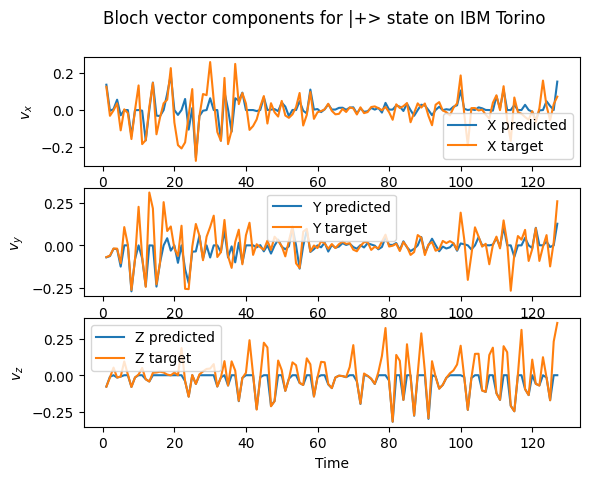

In [157]:
# plot the bloch vector as a function of time. Three lines in one plot for the x, y, z components of the bloch vector
# make into 3 subplots
from matplotlib import pyplot as plt
basis = '+'
linblad_parametrized_results = get_linblad_parametrized_results(params_plus)
time = np.arange(1,128,1)
fig, ax = plt.subplots(3,1)

# set main title
fig.suptitle(f'Bloch vector components for |{basis}> state on IBM Torino')

ax[0].plot(time, [linblad_parametrized_results[basis][i][0] for i in range(127)], label='X predicted')
ax[0].plot(time, [target_grads_dict[basis][i][0] for i in range(127)], label='X target')
ax[0].set_ylabel(r'$v_x$')
ax[0].legend()


ax[1].plot(time, [linblad_parametrized_results[basis][i][1] for i in range(127)], label='Y predicted')
ax[1].plot(time, [target_grads_dict[basis][i][1] for i in range(127)], label='Y target')
ax[1].set_ylabel(r'$v_y$')
ax[1].legend()

ax[2].plot(time, [linblad_parametrized_results[basis][i][2] for i in range(127)], label='Z predicted')
ax[2].plot(time, [target_grads_dict[basis][i][2] for i in range(127)], label='Z target')
ax[2].set_ylabel(r'$v_z$')
ax[2].legend()

# label x axis as time
plt.xlabel('Time')
# label y axis as Bloch vector component
plt.show()

/var/folders/8r/fcck2fx56mz4lc18dwtykgtw0000gn/T/ipykernel_1246/547080289.py:17: ComplexWarning: Casting complex values to real discards the imaginary part
  bloch_vector[i] = np.trace(np.dot(rho, pauli_matrices[i]))


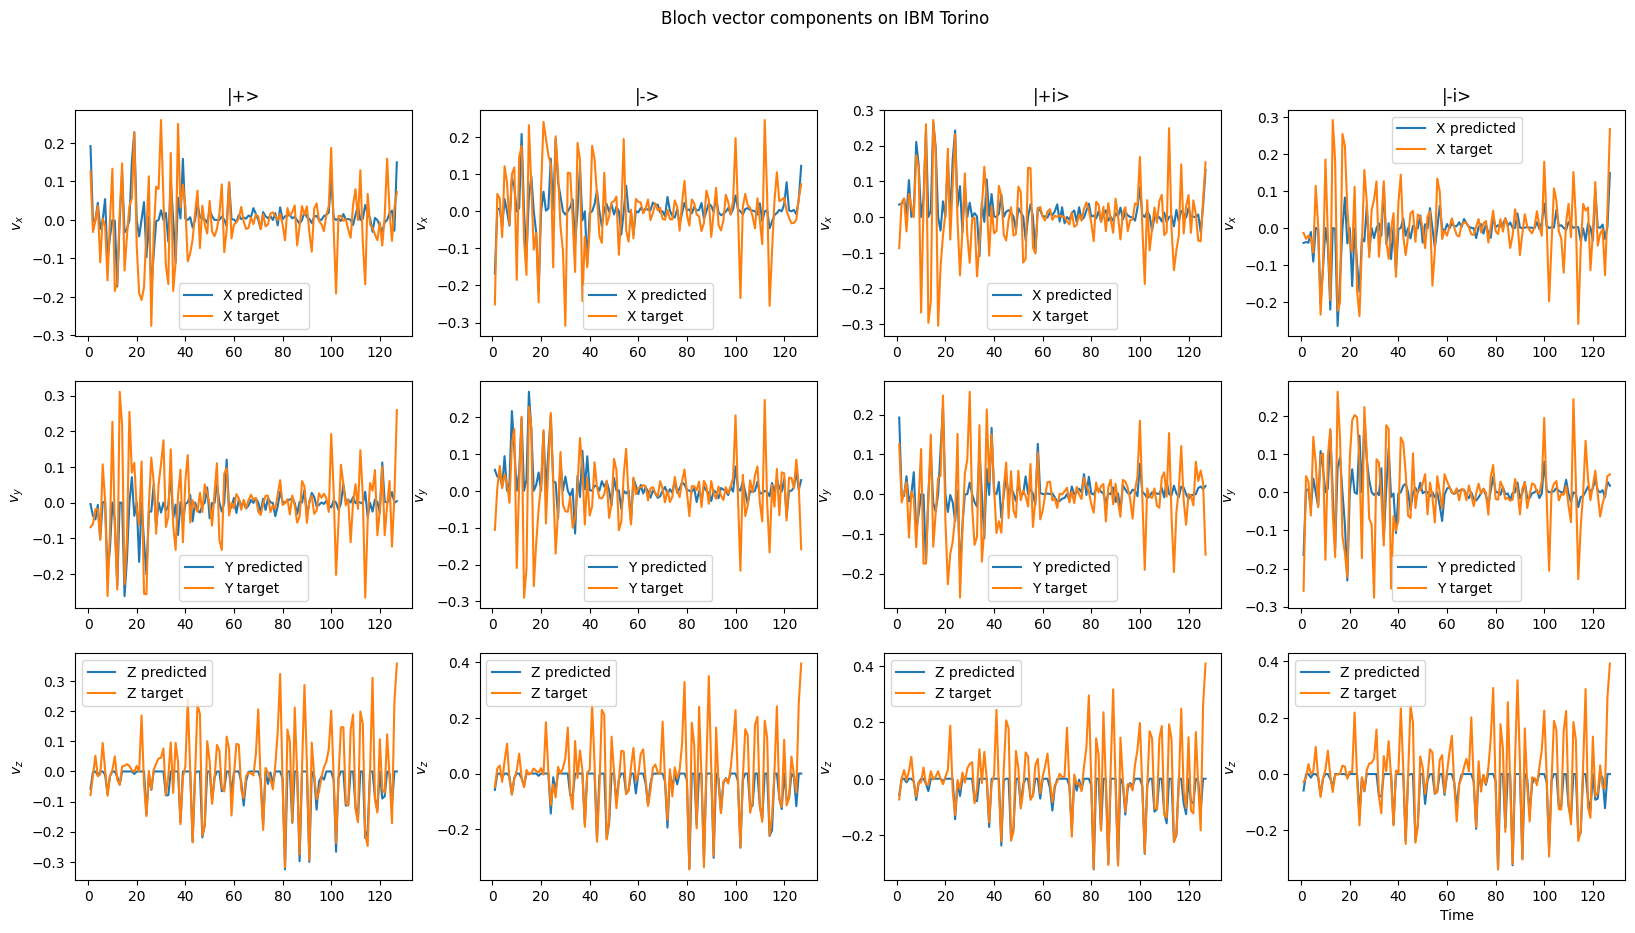

In [160]:
# plot the bloch vector as a function of time. Three lines in one plot for the x, y, z components of the bloch vector
# make into 3 subplots
from matplotlib import pyplot as plt
time = np.arange(1,128,1)
fig, ax = plt.subplots(3,4, figsize=(20,10))
x_y_linblad_parametrized_results = get_linblad_parametrized_results(x_y_basis_params)
 # set main title
fig.suptitle(f'Bloch vector components on IBM Torino')
for i, basis in enumerate(['+', '-', '+i', '-i']):

    # sub title for the column i
    ax[0,i].set_title(f'|{basis}>')
    
    ax[0,i].plot(time, [x_y_linblad_parametrized_results[basis][i][0] for i in range(127)], label='X predicted')
    ax[0,i].plot(time, [target_grads_dict[basis][i][0] for i in range(127)], label='X target')
    ax[0,i].set_ylabel(r'$v_x$')
    ax[0,i].legend()


    ax[1,i].plot(time, [x_y_linblad_parametrized_results[basis][i][1] for i in range(127)], label='Y predicted')
    ax[1,i].plot(time, [target_grads_dict[basis][i][1] for i in range(127)], label='Y target')
    ax[1,i].set_ylabel(r'$v_y$')
    ax[1,i].legend()

    ax[2,i].plot(time, [x_y_linblad_parametrized_results[basis][i][2] for i in range(127)], label='Z predicted')
    ax[2,i].plot(time, [target_grads_dict[basis][i][2] for i in range(127)], label='Z target')
    ax[2,i].set_ylabel(r'$v_z$')
    ax[2,i].legend()

# label x axis as time
plt.xlabel('Time')
# label y axis as Bloch vector component
plt.show()

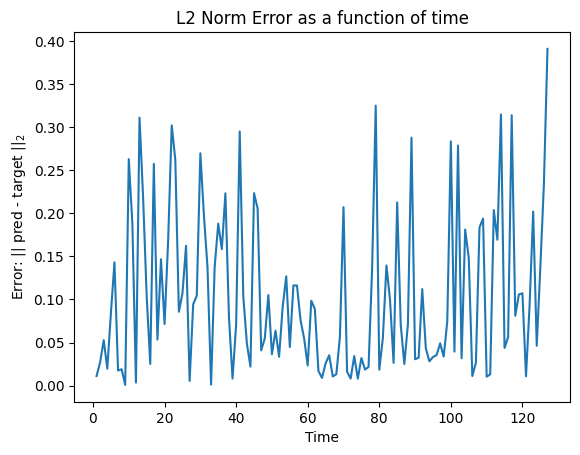

In [138]:
# error as a function of time
error = []
for i in range(127):
    error.append(np.linalg.norm(np.array(linblad_parametrized_results[basis][i]) - np.array(target_grads_dict[basis][i])))
plt.plot(time, error)
plt.title('L2 Norm Error as a function of time on IBM Torino')
plt.xlabel('Time')
plt.ylabel(r'Error: || pred - target $||_2$')
plt.show()

In [140]:
def get_optimal_linbladian_time_dependent_parameters_of_specific_initial_state(optimization_type='L-BFGS-B', initial_states=['+'], target_grads=target_grads_dict, loss_function='L2'):
    def mod_loss_of_bloch_vectors(parameters, target_grads, bloch_result_dict, initial_states):
        """
        Function that calculates the loss of the bloch vectors
        Args:
            parameters: the parameters of the lindbladian
            target_grads: the target gradients of the bloch vectors
            bloch_result_dict: the bloch vectors of the result data
        """
        parameters = parameters.reshape((127, 4))
        loss = 0
        for key in initial_states:
            target_grad = target_grads[key]
            
            bloch_result = bloch_result_dict[key]
            rho_result = [bloch_vector_to_density_matrix(bloch) for bloch in bloch_result]
            for i, rho in enumerate(rho_result):
                temp_grad_rho = apply_libladian(rho, parameters[i])
                linblad_bloch_result = density_matrix_to_bloch_vector(temp_grad_rho)
                if loss_function == 'L2':
                    loss += np.linalg.norm(linblad_bloch_result - target_grad[i])
                else:
                    loss += np.sum((linblad_bloch_result - target_grad[i])**2)
        return loss

    # Define bounds for each parameter at each time step
    bounds = []
    for _ in range(127):
        # bounds for: f, omega_Z, gamma_Z, gamma_AD
        bounds.extend([(0, 0.5), (0, 1), (0, 1), (0, 1)])  # Using a very small value close to zero for d > 0

    bounds = np.array(bounds)
    # Initial guess of the parameters
    initial_guess = get_initial_guess()

    # Minimize the loss function
    result = minimize(
        mod_loss_of_bloch_vectors,
        initial_guess,
        args=(target_grads, bloch_result_dict, initial_states),
        method=optimization_type,
        bounds=bounds
    )
    total_loss = result.fun
    parameters = result.x.reshape((127, 4))
    return total_loss, parameters

In [132]:
# read in csv data 
import pandas as pd
cols = ['X','Y','Z']
data = pd.read_csv('sol_opt.csv', names=cols, header=None)
data.head()
len(data)

127

In [130]:
data.to_numpy().shape

(127, 3)

In [143]:
t = np.arange(0,127,1)
sim_loss_other, sim_params_other = get_optimal_linbladian_time_dependent_parameters_of_specific_initial_state(initial_states=['+'], target_grads={'+' : data.to_numpy()}, loss_function='other')
print("Simulation optimization")
print(f"loss = {sim_loss_other}")
print(sim_params_other[0])

/var/folders/8r/fcck2fx56mz4lc18dwtykgtw0000gn/T/ipykernel_1246/547080289.py:17: ComplexWarning: Casting complex values to real discards the imaginary part
  bloch_vector[i] = np.trace(np.dot(rho, pauli_matrices[i]))


Simulation optimization
loss = 21.084351050964724
[6.37877915e-05 0.00000000e+00 6.63693118e-01 1.44927364e-03]


In [145]:
sim_lindblad_parametrized_results_other = get_linblad_parametrized_results(sim_params_other)

/var/folders/8r/fcck2fx56mz4lc18dwtykgtw0000gn/T/ipykernel_1246/547080289.py:17: ComplexWarning: Casting complex values to real discards the imaginary part
  bloch_vector[i] = np.trace(np.dot(rho, pauli_matrices[i]))


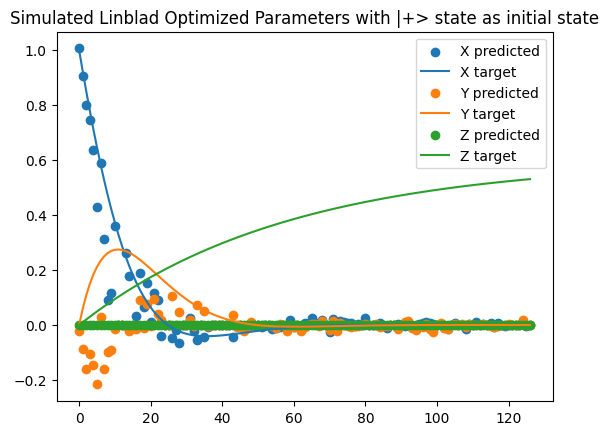

In [158]:
plt.title(r'Simulated Linblad Optimized Parameters with |+> state as initial state')
plt.scatter(t, [sim_lindblad_parametrized_results_other['+'][i][0] for i in range(127)], label='X predicted', marker='o')
plt.plot(t, [data['X'][i] for i in range(127)], label='X target')
plt.scatter(t, [sim_lindblad_parametrized_results_other['+'][i][1] for i in range(127)], label='Y predicted', marker='o')
plt.plot(t, [data['Y'][i] for i in range(127)], label='Y target')
plt.scatter(t, [sim_lindblad_parametrized_results_other['+'][i][2] for i in range(127)], label='Z predicted', marker='o')
plt.plot(t, [data['Z'][i] for i in range(127)], label='Z target')
plt.legend()
plt.show()

In [ ]:
t = np.arange(0,127,1)
sim_loss_other, sim_params_other = get_optimal_linbladian_time_dependent_parameters_of_specific_initial_state(initial_states=['+'], target_grads={'+' : data.to_numpy()}, loss_function='other')
print("Simulation optimization")
print(f"loss = {sim_loss_other}")
print(sim_params_other[0])

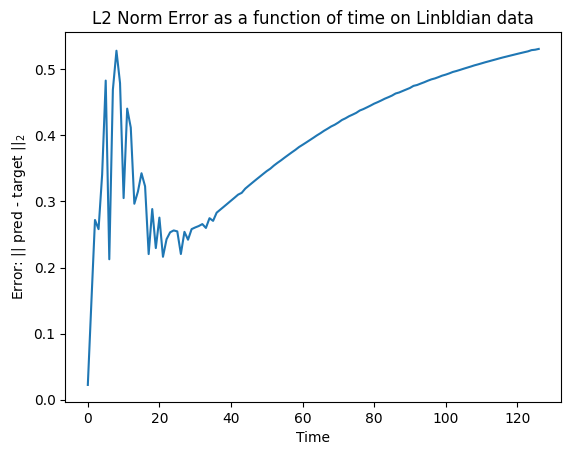

In [139]:
# error as a function of time for simulated data
error = []
for i in range(127):
    error.append(np.linalg.norm(np.array(sim_lindblad_parametrized_results_other['+'][i]) - np.array(data.to_numpy()[i])))
plt.plot(t, error)
plt.title('L2 Norm Error as a function of time on Linbldian data')
plt.xlabel('Time')
plt.ylabel(r'Error: || pred - target $||_2$')
plt.show()

In [141]:
t = np.arange(0,127,1)
sim_loss, sim_params = get_optimal_linbladian_time_dependent_parameters_of_specific_initial_state(initial_states=['+'], target_grads={'+' : data.to_numpy()}, loss_function='L2')
print("Simulation optimization")
print(f"loss = {sim_loss}")
print(sim_params[0])
sim_lindblad_parametrized_results = get_linblad_parametrized_results(sim_params)

/var/folders/8r/fcck2fx56mz4lc18dwtykgtw0000gn/T/ipykernel_1246/547080289.py:17: ComplexWarning: Casting complex values to real discards the imaginary part
  bloch_vector[i] = np.trace(np.dot(rho, pauli_matrices[i]))


Simulation optimization
loss = 50.133942250233
[0.         0.         0.65831828 0.        ]


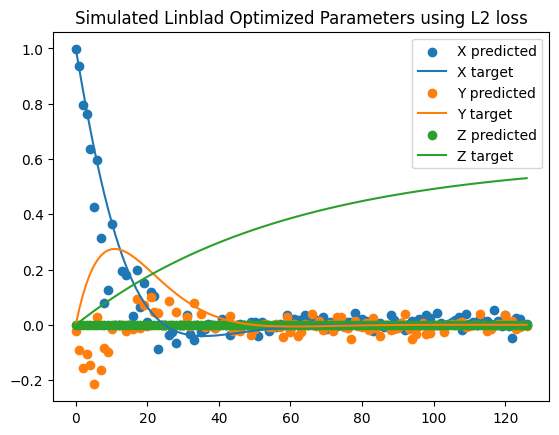

In [146]:
plt.title('Simulated Linblad Optimized Parameters using L2 loss')
plt.scatter(t, [sim_lindblad_parametrized_results['+'][i][0] for i in range(127)], label='X predicted', marker='o')
plt.plot(t, [data['X'][i] for i in range(127)], label='X target')
plt.scatter(t, [sim_lindblad_parametrized_results['+'][i][1] for i in range(127)], label='Y predicted', marker='o')
plt.plot(t, [data['Y'][i] for i in range(127)], label='Y target')
plt.scatter(t, [sim_lindblad_parametrized_results['+'][i][2] for i in range(127)], label='Z predicted', marker='o')
plt.plot(t, [data['Z'][i] for i in range(127)], label='Z target')
plt.legend()
plt.show()